In [1]:
pip install numPy pandas matplotlib seaborn scikit-learn jupyterlab


   ---------------------------------------- 0/2 [lark]
   ---------------------------------------- 2/2 [rfc3987-syntax]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt # We'll need this for plotting

# Construct the path to the data file relative to the notebook
DATA_PATH = os.path.join("..", "data", "processed", "master_dataset_india.csv")

# Load the dataset
df = pd.read_csv(DATA_PATH)

print("✅ Data loaded successfully!")
print("\n--- DataFrame Info ---")
df.info() # Prints a summary of columns and data types

print("\n--- First 5 Rows ---")
print(df.head()) # Shows the first few rows

print("\n--- Basic Statistics ---")
print(df.describe()) # Shows summary statistics for numeric columns

✅ Data loaded successfully!

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 23 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   Country_Name                                                        53 non-null     object 
 1   Year                                                                53 non-null     int64  
 2   EDGAR_BC_1970_2022                                                  53 non-null     float64
 3   EDGAR_CO_1970_2022                                                  53 non-null     float64
 4   EDGAR_NH3_1970_2022                                                 53 non-null     float64
 5   EDGAR_NMVOC_1970_2022                                               53 non-null     float64
 6   EDGAR_NOx_1970_2022                                             

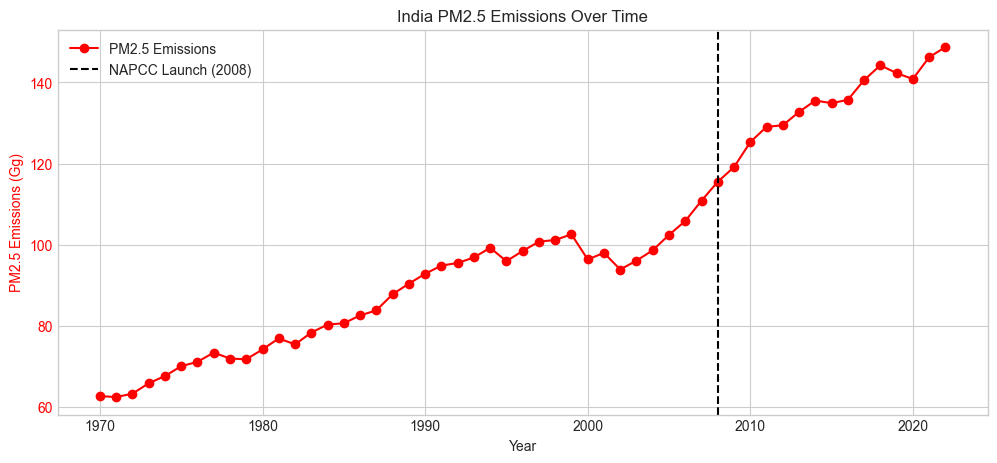

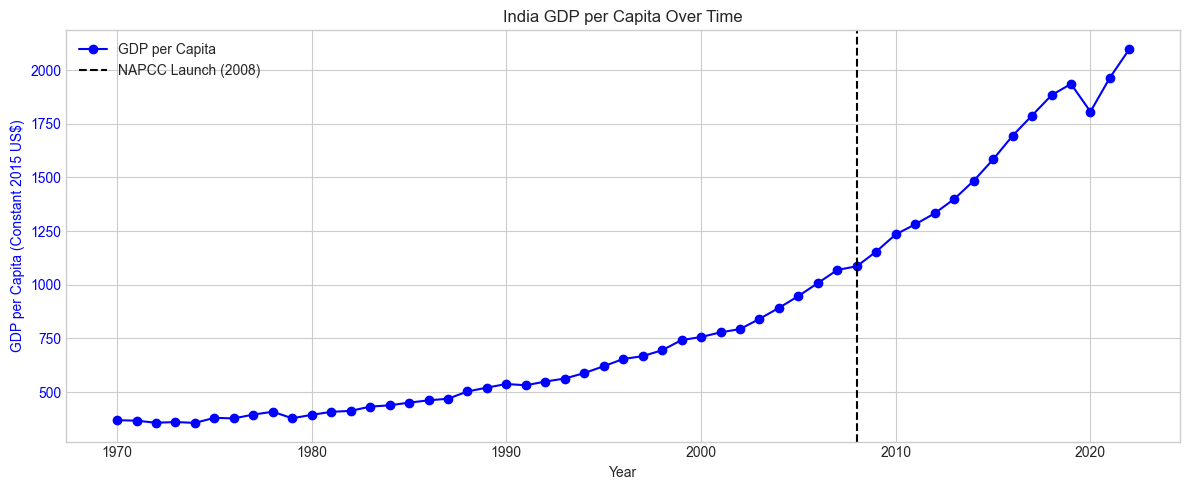

In [3]:
# --- Plotting Setup ---
# Make sure plots appear inline in the notebook
%matplotlib inline 
# Use a nice style
plt.style.use('seaborn-v0_8-whitegrid')

# --- Plot 1: PM2.5 Emissions ---
fig, ax1 = plt.subplots(figsize=(12, 5)) # Create a figure and one axes

# Plot PM2.5 data on the first axes
# NOTE: Your PM2.5 column name might be slightly different. Check df.columns if you get an error.
pm25_col = 'EDGAR_PM2' # Adjust if your column name is different
ax1.plot(df['Year'], df[pm25_col], label='PM2.5 Emissions', color='red', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('PM2.5 Emissions (Gg)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_title('India PM2.5 Emissions Over Time')

# Add vertical line for the policy intervention
ax1.axvline(x=2008, color='black', linestyle='--', label='NAPCC Launch (2008)')
ax1.legend(loc='upper left')
ax1.grid(True)


# --- Plot 2: GDP per Capita ---
fig, ax2 = plt.subplots(figsize=(12, 5)) # Create a second figure

# Plot GDP data
gdp_col = 'GDP per capita (constant 2015 US$)'
ax2.plot(df['Year'], df[gdp_col], label='GDP per Capita', color='blue', marker='o')
ax2.set_xlabel('Year')
ax2.set_ylabel('GDP per Capita (Constant 2015 US$)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_title('India GDP per Capita Over Time')

# Add vertical line for the policy intervention
ax2.axvline(x=2008, color='black', linestyle='--', label='NAPCC Launch (2008)')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show() # Display the plots

In [4]:
!pip install dowhy econml

In [5]:
# --- 1. Install DoWhy (if you haven't already) ---
# You might need to run this in your terminal: pip install dowhy
# Or uncomment and run this cell:
# !pip install dowhy econml

# --- 2. Prepare Data for DoWhy ---
print("--- Preparing data for DoWhy ---")

# Copy the dataframe to avoid changing the original
df_model = df.copy()

# Rename columns for easier use in DoWhy/EconML
# We need shorter names without spaces or special chars
df_model = df_model.rename(columns={
    'EDGAR_PM2': 'pm25_emissions', # Our outcome variable
    'policy_NAPCC_active': 'treatment', # Our policy variable
    'GDP per capita (constant 2015 US$)': 'confounder_gdp',
    'Industry (including construction), value added (% of GDP)': 'confounder_industry_pct',
    'Population, total': 'confounder_population',
    'Renewable energy consumption (% of total final energy consumption)': 'confounder_renewables_pct'
})

# Select only the columns needed for the model
# (Add other pollutants later if you want to test them)
cols_for_model = [
    'Year',
    'pm25_emissions',
    'treatment',
    'confounder_gdp',
    'confounder_industry_pct',
    'confounder_population',
    'confounder_renewables_pct'
]
df_model = df_model[cols_for_model]

# --- 3. Handle Missing Data (Simple Forward Fill) ---
# The 'Renewable energy...' column had many NaNs.
# Forward fill propagates the last valid observation forward.
# We should ideally use a more sophisticated method later (like interpolation).
missing_before = df_model.isnull().sum().sum()
df_model = df_model.ffill()
missing_after = df_model.isnull().sum().sum()

# If there were still NaNs at the beginning, backfill them
if missing_after > 0:
    df_model = df_model.bfill()
    missing_after = df_model.isnull().sum().sum()

print(f"Handled missing values. Missing count before: {missing_before}, after: {missing_after}")

print("\n--- Cleaned DataFrame for Model ---")
print(df_model.head())
print("\n--- Data Types ---")
print(df_model.info()) # Check that all columns are numeric

--- Preparing data for DoWhy ---
Handled missing values. Missing count before: 21, after: 0

--- Cleaned DataFrame for Model ---
   Year  pm25_emissions  treatment  confounder_gdp  confounder_industry_pct  \
0  1970       62.735335          0      369.192481                21.729309   
1  1971       62.488069          0      367.033310                22.392008   
2  1972       63.332115          0      357.077929                22.408003   
3  1973       65.885815          0      360.637844                21.348230   
4  1974       67.683233          0      356.615070                22.675693   

   confounder_population  confounder_renewables_pct  
0            545864268.0                       53.0  
1            558096387.0                       53.0  
2            570482142.0                       53.0  
3            583465598.0                       53.0  
4            597041391.0                       53.0  

--- Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53

In [18]:
!pip install pygraphviz logging dowhy econml

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pygraphviz


  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [94 lines of output]
      C:\Users\Admin\AppData\Local\Temp\pip-build-env-1mg_9a1f\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              **********************************************

In [20]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pydot in c:\users\admin\appdata\local\programs\python\python310\lib\site-packages (4.0.1)




[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
from dowhy import CausalModel
import logging
# Optional: Suppress excessive logging from DoWhy/EconML if needed
# logging.getLogger("dowhy").setLevel(logging.WARNING)

# --- Define Model Components Directly ---
common_causes = [
    'confounder_gdp',
    'confounder_industry_pct',
    'confounder_population',
    'confounder_renewables_pct',
    'Year' # Include Year directly as a common cause
]

print("--- Step 1: Defining Causal Model (using common_causes) ---")
# Instead of passing the graph string, we pass the list of confounders
model = CausalModel(
    data=df_model,
    treatment='treatment',
    outcome='pm25_emissions',
    common_causes=common_causes # Directly specify confounders
)

# --- Skip Graph Visualization ---
print("Skipping graph visualization due to dependency issues.")


# --- 2. Identify the Causal Effect ---
# DoWhy finds a valid statistical method based on the common causes.
print("\n--- Step 2: Identifying Causal Estimand ---")
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


# --- 3. Estimate the Causal Effect (ATE) ---
# We'll use linear regression as a simple baseline estimator.
print("\n--- Step 3: Estimating the Average Treatment Effect (ATE) ---")
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True # Adds statistical significance test
)

print("\n--- Causal Estimate ---")
print(estimate)
print(f"\nEstimated Causal Effect (ATE): {estimate.value:.3f}")


# --- 4. Refute the Estimate ---
# Placebo Treatment: Randomly assigns the treatment dates. Should find near-zero effect.
print("\n--- Step 4: Refuting the Estimate (Placebo Test) ---")
refute_placebo = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute", # Randomly shuffle treatment assignment
    num_simulations=100 # Run 100 random shuffles
)

print("\n--- Placebo Refutation Results ---")
print(refute_placebo)

--- Step 1: Defining Causal Model (using common_causes) ---
Skipping graph visualization due to dependency issues.

--- Step 2: Identifying Causal Estimand ---
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                                                                   ↪
────────────(E[pm_25_emissions|confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Ye ↪
d[treatment]                                                                                                             ↪

↪     
↪ ar])
↪     
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→pm25_emissions then P(pm25_emissions|treatment,confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Year,U) = P(pm25_emissions|treatment,confounder_population,confounder_gdp,confounder_renewables_pct,confounder_industry_pct,Year)

### Estiman

D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D


--- Placebo Refutation Results ---
Refute: Use a Placebo Treatment
Estimated effect:11.772897842043648
New effect:-0.031369328609723086
p value:1.0



D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
D:\Installed\python3.12\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D